<a href="https://colab.research.google.com/github/filippotessaro/deep-neural-decision-forest/blob/master/DEEP_RANDOM_FOREST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Neural Decision Forest

This is the code of the Deep Learning Project (2019). Emotion recognition has been intesively exploited in the most recent years, due to the low-cost technologies involved and the interest derived from different fields of research, like psychology, psychiatry, neuroscience and computer science in general. Even if the interest in the topic had been constantly growing, the available datasets are still a small number. For this research we decided to test our network on the RAVDESS dataset, which contains audio and video data coming from 24 authors who emulate different emotions. 

Our problem is doing an audio emotion recognition using a particular kind of architecture: the deep random forest. This architecture has been tested on the MNIST dataset and on other image dataset while here we apply the network on audio data, which are converted in coefficient through an MFCC and then processed.

This project follows the guide lines of the paper: [ Deep Neural Decision Forests](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/Kontschieder_Deep_Neural_Decision_ICCV_2015_paper.pdf).

## Plotting the audio file's waveform and its spectrogram

In [0]:
#Load libraries
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from sklearn.metrics import confusion_matrix
% pylab inline
import pandas as pd
import glob 

In [0]:
#file audio loading with librosa
data, sampling_rate = librosa.load('RawData/f11 (01).wav')

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [0]:
import scipy.io.wavfile
import sys

sr,x = scipy.io.wavfile.read('RawData/f10 (01).wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## Getting Data from joblib files

Joblib is a powerful Python package for management of computation: parallel computing, caching, and primitives for out-of-core computing. It is handy when working on so called big data, that can consume more than the available RAM (several GB nowadays). In such situations, objects in the working space must be persisted to disk, for out-of-core computing, distribution of jobs, or caching.

For data management, joblib provides transparent disk persistence that is very efficient with such objects. The internal mechanism relies on specializing pickle to handle better numpy arrays.

On this project, we have decided to store our features and our output labels in two distinct joblib files. The main reason in doing this, is for the fact that with this file format we have reduced the loading time of the audio files.

In [2]:
#PROVA NUOVO DATASET
import joblib
from sklearn.model_selection import train_test_split
import numpy as np
from tensorboardcolab import TensorBoardColab

# Loading saved models
X = joblib.load('X.joblib')
print(len(X))
y = joblib.load('y.joblib')
print(len(y))


#Add new dataset
'''X_Sentelli = joblib.load('X_Sentelli.joblib')
y_Sentelli = joblib.load('y_Sentelli.joblib')

print(len(y_Sentelli))# 4904 + 9237

X_new = np.append(X, X_Sentelli, axis=0)
print(len(X_new))
y_new = np.append (y, y_Sentelli, axis=0)'''

#Train 70 - Test 30 random splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

4904
4904


## Simple Sklearn Random Forest Implementation
Our target is to beat the accuracy of this model with a deep neural network.

In [0]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

def random_forest_classifier(features, target):
    """
    To train the random forest classifier with features and target data
    :param features:
    :param target:
    :return: trained random forest classifier
    """
    clf = RandomForestClassifier()
    clf.fit(features, target)
    return clf

Train and Test the random forest model:

In [4]:
# Create random forest classifier instance
trained_model = random_forest_classifier(X_train, y_train)
predictions = trained_model.predict(X_test)

print("Train Accuracy :: ", accuracy_score(y_train, trained_model.predict(X_train)))
print("Test Accuracy  :: ", accuracy_score(y_test, predictions))
print(" Confusion matrix \n", confusion_matrix(y_test, predictions))

Train Accuracy ::  0.9975646879756469
Test Accuracy  ::  0.8684373069796171
 Confusion matrix 
 [[119   2   0   4   0   0   0   2]
 [ 15 215   0   4   0   2   1   0]
 [  2  17 227   5   3   4   2   3]
 [  4  11   7 205   3   6   4   4]
 [  0   2   7   8 217   0   4   2]
 [  4   2   3  11  11 221   2   2]
 [  2   4   2   1   0   1 105   3]
 [  1   9   6   7   4   2   8  97]]


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Target Results:

*   Train Accuracy :  0.99
*   Test Accuracy  :  0.87



## Deep Random Forest

In [0]:
from numpy import genfromtxt
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.utils.data as Data
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from torch.nn.parameter import Parameter
import torch.nn.functional as F


### Network Model Definition

In [0]:
class DeepNeuralDecisionForest(nn.Module):
    def __init__(self, p_keep_conv, p_keep_hidden, n_leaf, n_label, n_tree, n_depth, batch_size):
        super(DeepNeuralDecisionForest, self).__init__()

        #Case CNN as input to Deep Random Forest
        '''self.conv = nn.Sequential()
        self.conv.add_module('conv1', nn.Conv1d(in_channels = 40,out_channels = 64,kernel_size = 1,stride = 1))
        self.conv.add_module('relu1', nn.ReLU())
        self.conv.add_module('pool1', nn.MaxPool1d(kernel_size=5))
        self.conv.add_module('drop1', nn.Dropout(1-p_keep_conv))
        self.conv.add_module('conv2', nn.Conv1d(64, 128, kernel_size=1))
        self.conv.add_module('relu2', nn.ReLU())
        self.conv.add_module('pool2', nn.BatchNorm1d(128))
        self.conv.add_module('drop2', nn.Dropout(1-p_keep_conv))'''
        
        self.fc1 = nn.Sequential(
			   nn.Linear(40, 64),
			   nn.ReLU(),
         nn.BatchNorm1d(64),
         nn.Dropout(1-p_keep_conv))

        self._nleaf = n_leaf
        self._nlabel = n_label
        self._ntree = n_tree
        self._ndepth = n_depth
        self._batchsize = batch_size

        self.treelayers = nn.ModuleList()
        self.pi_e = nn.ParameterList()
        for i in range(self._ntree):
            treelayer = nn.Sequential()
            treelayer.add_module('sub_linear1', nn.Linear(64, 128))
            treelayer.add_module('sub_relu', nn.ReLU())
            treelayer.add_module('sub_drop1', nn.Dropout(1-p_keep_hidden))
            treelayer.add_module('sub_batchNorm', nn.BatchNorm1d(128))
            treelayer.add_module('sub_linear2', nn.Linear(128, self._nleaf))
            treelayer.add_module('sub_sigmoid', nn.Sigmoid())
            
            self.treelayers.append(treelayer)
            self.pi_e.append(Parameter(self.init_prob_weights([self._nleaf, self._nlabel], -2, 2)))

    def init_pi(self):
        return torch.ones(self._nleaf, self._nlabel)/float(self._nlabel)

    def init_weights(self, shape):
        return torch.randn(shape).uniform(-0.01,0.01)

    def init_prob_weights(self, shape, minval=-5, maxval=5):
        return torch.Tensor(shape[0], shape[1]).uniform_(minval, maxval)

    def compute_mu(self, flat_decision_p_e):
        n_batch = self._batchsize
        batch_0_indices = torch.range(0, n_batch * self._nleaf - 1, self._nleaf).unsqueeze(1).repeat(1, self._nleaf).long()

        in_repeat = self._nleaf // 2
        out_repeat = n_batch

        batch_complement_indices = torch.LongTensor(
            np.array([[0] * in_repeat, [n_batch * self._nleaf] * in_repeat] * out_repeat).reshape(n_batch, self._nleaf))

        # First define the routing probabilistics d for root nodes
        mu_e = []
        indices_var = Variable((batch_0_indices + batch_complement_indices).view(-1)) 
        indices_var = indices_var.cuda()
        # iterate over each tree
        for i, flat_decision_p in enumerate(flat_decision_p_e):
            mu = torch.gather(flat_decision_p, 0, indices_var).view(n_batch, self._nleaf)
            mu_e.append(mu)

        # from the scond layer to the last layer, we make the decison nodes
        for d in range(1, self._ndepth + 1):
            indices = torch.range(2 ** d, 2 ** (d + 1) - 1) - 1
            tile_indices = indices.unsqueeze(1).repeat(1, 2 ** (self._ndepth - d + 1)).view(1, -1)
            batch_indices = batch_0_indices + tile_indices.repeat(n_batch, 1).long()

            in_repeat = in_repeat // 2
            out_repeat = out_repeat * 2
            # Again define the indices that picks d and 1-d for the nodes
            batch_complement_indices = torch.LongTensor(
                np.array([[0] * in_repeat, [n_batch * self._nleaf] * in_repeat] * out_repeat).reshape(n_batch, self._nleaf))

            mu_e_update = []
            indices_var = Variable((batch_indices + batch_complement_indices).view(-1))
            indices_var = indices_var.cuda()
            for mu, flat_decision_p in zip(mu_e, flat_decision_p_e):
                mu = torch.mul(mu, torch.gather(flat_decision_p, 0, indices_var).view(
                    n_batch, self._nleaf))
                mu_e_update.append(mu)
            mu_e = mu_e_update
        return mu_e

    def compute_py_x(self, mu_e, leaf_p_e):
        py_x_e = []
        n_batch = self._batchsize

        for i in range(len(mu_e)):
            py_x_tree = mu_e[i].unsqueeze(2).repeat(1, 1, self._nlabel).mul(leaf_p_e[i].unsqueeze(0).repeat(n_batch, 1, 1)).mean(1)
            py_x_e.append(py_x_tree.squeeze().unsqueeze(0))

        py_x_e = torch.cat(py_x_e, 0)
        py_x = py_x_e.mean(0).squeeze()
        
        return py_x

    def forward(self, x):
        x = x.view(-1, 40)#DELETE
        feat = self.fc1.forward(x)#DELETE
        #feat = self.conv.forward(x)
        #print('out 8', feat.shape)
        
        feat = feat.view(-1, 64)
        self._batchsize = x.size(0)

        flat_decision_p_e = []
        leaf_p_e = []
        
        for i in range(len(self.treelayers)):
            decision_p = self.treelayers[i].forward(feat)
            decision_p_comp = 1 - decision_p
            decision_p_pack = torch.cat((decision_p, decision_p_comp))
            flat_decision_p = decision_p_pack.view(-1)
            flat_decision_p_e.append(flat_decision_p)
            leaf_p = F.softmax(self.pi_e[i])
            leaf_p_e.append(leaf_p)
        
        mu_e = self.compute_mu(flat_decision_p_e)
        
        py_x = self.compute_py_x(mu_e, leaf_p_e)
        return torch.log(py_x)


In [0]:
def train(net,data_loader,optimizer,cost_function, device='cuda'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.
  
  # Set the network in train mode
  net.train()
  
  # Loop over the dataset
  for batch_idx, (inputs, targets) in enumerate(data_loader):
    # Load data into GPU
    inputs = inputs.to(device)
    
    targets = targets.to(device)
    
    # Forward pass
    outputs = net(inputs)

    # Apply the loss
    loss = cost_function(outputs, targets)
      
    # Backward pass
    loss.backward()
    
    # Update parameters
    optimizer.step()
    
    # Reset the optimizer
    optimizer.zero_grad()

    # Better print something, no?
    samples+=inputs.shape[0]
    cumulative_loss += loss.item()
    _, predicted = outputs.max(1)
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100


def test(net, data_loader, cost_function, device='cuda'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  #Set the network in eval mode
  net.eval()
  with torch.no_grad(): # torch.no_grad() disables the autograd machinery, thus not saving the intermediate activations
    # Loop over the dataset
    for batch_idx, (inputs, targets) in enumerate(data_loader):
      # Load data into GPU
      inputs = inputs.to(device)

      targets = targets.to(device)

      # Forward pass
      outputs = net(inputs)

      # Apply the loss
      loss = cost_function(outputs, targets)

      # Better print something
      samples+=inputs.shape[0]
      cumulative_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors
      _, predicted = outputs.max(1)
      cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100


In [0]:
def get_cost_function():
  cost_function = torch.nn.CrossEntropyLoss()
  return cost_function


In [0]:
def get_optimizer(net, lr, wd, momentum):
  optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)
  return optimizer


In [0]:
def get_data(batch_size, test_batch_size=128): 
  # Load data
  #X_train, X_test, y_train, y_test
  train_data = Data.TensorDataset(
    torch.from_numpy(X_train).float(), 
    torch.from_numpy(y_train).long())

  test_data = Data.TensorDataset(
    torch.from_numpy(X_test).float(), 
    torch.from_numpy(y_test).long())

  # Initialize dataloaders
  train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)
  
  return train_loader, test_loader


In [24]:
# Instantiate visualizer
tb = TensorBoardColab(graph_path='./log')
visualization_name='Deep Random Forest'

device='cuda:0'
momentum = 0.95
learning_rate = 0.003 #In the case with the new dataset: 0.0007
num_epochs = 1000
weight_decay = 1e-5

DEPTH = 3  # Depth of a tree
N_LEAF = 2 ** (DEPTH + 1)  # Number of leaf node
N_LABEL = 8  # Number of classes
N_TREE = 3  # Number of trees
batch_size = 256

# Dropout Network hyperparameters
p_conv_keep = 0.9
p_full_keep = 0.6

    
#DataLoader creation
train_loader, test_loader = get_data(batch_size)

#Network initialization
net = DeepNeuralDecisionForest(p_keep_conv = p_conv_keep, p_keep_hidden = p_full_keep, n_leaf= N_LEAF, n_label= N_LABEL, n_tree= N_TREE, n_depth= DEPTH, batch_size=batch_size)
net.to(device)

optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)
cost_function = get_cost_function()

train_accuracy_list = list()
test_accuracy_list = list()

train_loss_list = list()
test_loss_list = list()

print('Before training:')
train_loss, train_accuracy = test(net, train_loader, cost_function)
test_loss, test_accuracy = test(net, test_loader, cost_function)
train_accuracy_list.append(train_accuracy)
test_accuracy_list.append(test_accuracy)
train_loss_list.append(train_loss)
test_loss_list.append(test_loss)


print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
print('-----------------------------------------------------')


# Add values to plots
tb.save_value('Loss/train_loss', visualization_name, 0, train_loss)
tb.save_value('Loss/test_loss', visualization_name, 0, test_loss)
tb.save_value('Accuracy/train_accuracy', visualization_name, 0, train_accuracy)
tb.save_value('Accuracy/test_accuracy', visualization_name, 0, test_accuracy)

# Update plots 
tb.flush_line(visualization_name)

for e in range(num_epochs):
  train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
  val_loss, val_accuracy = test(net, test_loader, cost_function)
  print('Epoch: {:d}'.format(e+1))
  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('-----------------------------------------------------')
  
  train_accuracy_list.append(train_accuracy)
  test_accuracy_list.append(val_accuracy)
  train_loss_list.append(train_loss)
  test_loss_list.append(val_loss)
  
  # Add values to plots
  tb.save_value('Loss/train_loss', visualization_name, e + 1, train_loss)
  tb.save_value('Loss/test_loss', visualization_name, e + 1, val_loss)
  tb.save_value('Accuracy/train_accuracy', visualization_name, e + 1, train_accuracy)
  tb.save_value('Accuracy/test_accuracy', visualization_name, e + 1, val_accuracy)
  # Update plots 
  tb.flush_line(visualization_name)
  
print('After training:')
train_loss, train_accuracy = test(net, train_loader, cost_function)
test_loss, test_accuracy = test(net, test_loader, cost_function)

print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
print('-----------------------------------------------------')

Wait for 8 seconds...
TensorBoard link:
https://6e9da782.ngrok.io
Before training:
	 Training loss 0.00859, Training accuracy 7.58
	 Test loss 0.00935, Test accuracy 8.28
-----------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:123: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].


Epoch: 1
	 Training loss 0.00787, Training accuracy 23.07
	 Test loss 0.00892, Test accuracy 15.44
-----------------------------------------------------
Epoch: 2
	 Training loss 0.00734, Training accuracy 33.18
	 Test loss 0.00814, Test accuracy 26.93
-----------------------------------------------------
Epoch: 3
	 Training loss 0.00695, Training accuracy 37.69
	 Test loss 0.00827, Test accuracy 22.54
-----------------------------------------------------
Epoch: 4
	 Training loss 0.00666, Training accuracy 41.98
	 Test loss 0.00788, Test accuracy 30.51
-----------------------------------------------------
Epoch: 5
	 Training loss 0.00642, Training accuracy 46.54
	 Test loss 0.00749, Test accuracy 35.89
-----------------------------------------------------
Epoch: 6
	 Training loss 0.00621, Training accuracy 50.23
	 Test loss 0.00714, Test accuracy 43.92
-----------------------------------------------------
Epoch: 7
	 Training loss 0.00601, Training accuracy 53.00
	 Test loss 0.00718, Tes

### Accuracy plot

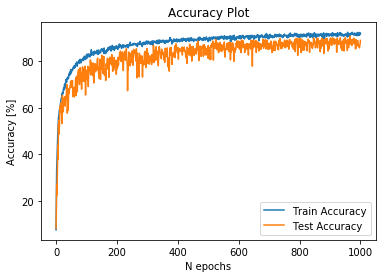

In [25]:
import matplotlib.pyplot as plt
x = range(0,num_epochs +1)

plt.plot(x, train_accuracy_list, label='Train Accuracy')
plt.plot(x, test_accuracy_list, label='Test Accuracy')

plt.xlabel('N epochs')
plt.ylabel('Accuracy [%]')
plt.title("Accuracy Plot")
plt.legend()
plt.show()

### Loss Plot


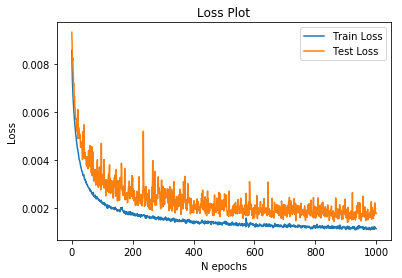

In [26]:
plt.plot(x, train_loss_list, label='Train Loss')
plt.plot(x, test_loss_list, label='Test Loss')

plt.xlabel('N epochs')
plt.ylabel('Loss')
plt.title("Loss Plot")
plt.legend()
plt.show()

## Confusion Matrix

In [22]:
'''test_loader_copy = test_loader
#val_loader_copy = val_loader
train_loader_copy = train_loader'''
net_copy = net
samples = 0.
cumulative_loss = 0.
cumulative_accuracy = 0.

net_copy.eval() # Strictly needed if network contains layers which has different behaviours between train and tes
predicted_label = list()
real_label = list()
#imgPath = list()
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        # Load data into GPU
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = net_copy(inputs)

        # Apply the loss
        loss = cost_function(outputs, targets)

        # Better print something
        samples+=inputs.shape[0]
        cumulative_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors
        _, predicted = outputs.max(1)
        predicted_label.extend(predicted.tolist())
        real_label.extend(targets.tolist())
        cumulative_accuracy += predicted.eq(targets).sum().item()
        
print("Final Accuracy: ", cumulative_accuracy/samples*100, "%")


Final Accuracy:  86.34959851760345 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:123: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].


Test items:  1619


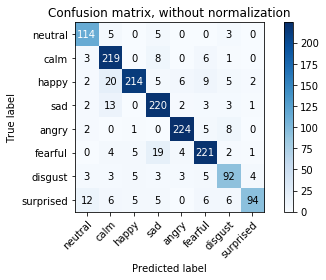

In [23]:
#print(__doc__)
from sklearn.utils.multiclass import unique_labels

#Classes to be predicted
class_names = ['neutral','calm','happy', 'sad','angry','fearful','disgust','surprised']

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

print("Test items: ", len(predicted_label))

# Plot confusion matrix
plot_confusion_matrix(real_label,predicted_label, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()